In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import gym
np.random.seed(0)
tf.random.set_seed(0)
%matplotlib notebook

In [2]:
class Chart:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)
    
    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

# 第七章 回合更新策略梯度方法

* **最优价值算法**：利用价值函数，在求解最优策略过程中试图估计最优价值函数
  * 有模型价值迭代，回合更新，时序差分，函数近似
* **最优策略算法**：不直接估计最优价值函数，试图用含参函数近似最优策略，并通过迭代更新参数值

## 使用环境：车杆平衡CartPole-v0

一个小车可以在直线滑轨上移动，一个杆一头连接小车，另一头悬空，可以不完全直立。小车的初始位置和杆的初始角度都是在一定范围内随机选取的，智能体可以控制小车沿着滑轨左移一个单位或右移一段固定距离（移动幅度固定，而且不可以不移动）。出现以下任一情形时，回合结束：

1. 杆倾斜角度超过12°
2. 小车移动超过2.4个单位长度
3. 回合达到200步

每进行一步得到一个单位的奖励，我们希望回合尽可能的长，一般认为若在连续的100个回合内平均奖励≥195，则问题解决

观察值的四个分分量：小车位置$(-4.8， 4.8)$；速度$(-\infty, \infty)$；角度$(-41.8°,+41.8°)$；角速度$(-\infty, \infty)$。动作取值{0,1}

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print("观察空间 = {}".format(env.observation_space))
print("动作空间 = {}".format(env.action_space))

观察空间 = Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
动作空间 = Discrete(2)


## 策略梯度算法原理

**核心思想**：1. 用含参函数近似最优策略；2. 用策略梯度优化策略函数

### 函数近似和动作偏好

【**基本思想**】用含参函数$\pi(a|s;\theta)$来近似最优策略。

> 由于$\sum_a \pi(s|a) = 1$，也应有$\sum_a \pi(a|s;\theta)=1$

【**动作偏好函数**】记为$h(a,s;\theta)$，其softmax的值为$\pi(a|s;\theta)$，即：
$$
\pi(a|s;\theta) = \frac{\exp h(a,s;\theta)}{\sum_{a'}\exp h(a',s;\theta)}
$$

* 从动作价值函数导出的最优策略往往具有固定形式（如$\varepsilon$贪心策略）。从动作偏好导出的最优策略估计不拘泥于特定形式，每个动作都可以有不同的概率值，形式更加灵活。
* 如果需要迭代方法更新参数$\theta$，随着迭代的进行，$\pi(a|s;\theta)$可以自然而然地逼近确定性策略，不需要手动调节参数
* 动作偏好函数可以具有线性组合、人工神经网络等多种形式，在确定动作偏好的形式后，只需要再确定参数$\theta$的值，就可以确定整个最优状态估计。参数$\theta$的值常常通过基于梯度的迭代算法更新。

### 策略梯度定理

策略梯度定理给出了<u>期望回报</u>和<u>策略梯度</u>之间的关系，是策略梯度方法的基础。

【**内容**】在回合制任务中，策略$\pi(\theta)$的期望回报可以表示为$E_{\pi(\theta)}$的期望回报可以表示为$E_{\pi(\theta)}[G_0]$。策略梯度定理给出了其对参数$\theta$的梯度为：
$$
\nabla E_{\pi(\theta)}[G_0] = E\left[ \sum_{t=0}^{+\infty}\gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta) \right]
$$
等式的右边是和的期望，求和的$\gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta)$中，只有$\nabla \ln \pi(A_t|S_t;\theta)$显式含有参数$\theta$

策略梯度定理告诉我们：只要知道$\nabla \ln \pi(A_t|S_t;\theta)$的值和其他一些比较好获得的值，就可以得到期望回报的梯度。这样就可以顺着梯度方向改变$\theta$以增大期望回报

证明暂略

## 同策回合更新策略梯度算法

### 简单的策略梯度算法

每个回合结束后，我们可以就回合中的每一步用形如
$$
\theta_{t+1} \leftarrow \theta + \alpha \gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta)
$$

的迭代式来更新参数$\theta$，这样的算法称为**简单的策略梯度算法**（VPG）

$\alpha\gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta)$：REward Increment = Nonnegtive Factor * Offset Reinforcement * Characteristic Eligibility表示增量

在具体更新过程中不一定要严格采取这种形式，当采用TensorFlow等自动微分的软件包来学习参数时，可以定义单步损失为$-\gamma^tG_t\ln \pi(A_t|S_t;\theta)$，让软件包中的优化器减小整个回合中所有步的平均损失。就会沿着$\sum_{t=0}^{+\infty} \gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta)$的梯度方向改变$\theta$值

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】优化器（隐含学习率$\alpha$），折扣因子$\gamma$，控制回合数和步数的参数

1. 初始化：$\theta \leftarrow any$
2. 回合更新：对每个回合执行以下操作：
   1. 采样：用策略$\pi(\theta)$生成轨迹$S_0,A_0,R_1,S_1,\dots,S_{T-1},A_{T-1},R_T,S_T$
   2. 初始化回报：$G \leftarrow 0$
   3. 对$t = T-1,T-2,\dots,0$执行以下操作：
      1. 更新回报：$G \leftarrow \gamma G + R_{t+1}$
      2. 更新策略：更新$\theta$以减小$-\gamma^tG\ln\pi(A_t|S_t;\theta)$ （如$\theta_{t+1} \leftarrow \theta + \alpha \gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta)$）

### 带基线的简单策略梯度算法

为了降低学习过程中的方差，可以引入基线函数$B(s)$。基线函数$B$可以是任意随机函数或确定函数，但是只能和状态$s$有关，不能和动作$a$有关。满足这样的条件后则会有：
$$
E[\gamma^t(G_t-B(S_t))\nabla\ln\pi(A_t|S_t;\theta)] = E[\gamma^tG_t\nabla\ln\pi(A_t|S_t;\theta)]
$$
证明略。基线函数可以任意选择，例如以下情况：

1. 选择基线函数为由轨迹确定的随机变量$B(S_t) = -\sum_{\tau=0}^{t-1} \gamma^{\tau-1}R_{\tau+1}$，这时$\gamma^t(G_t - B(S_t)) = G_0$，梯度形式为$E[G_0\nabla\ln\pi(A_t|S_t;\theta)]$
2. 选择基线函数为$B(S_t) = \gamma^tv_*(S_t)$，这时梯度形式为$E[\gamma^t(G_t-v_*(S_t))\nabla\ln\pi(A_t|S_t;\theta)]$

在选择基线时，应该参考如下两个思想：

1. 基线的选择应当有效降低方差。可通过实践得知
2. 基线函数应当是可以得到的。

一个能有效降低方差的基线是状态价值函数的估计，采用状态价值函数估计为基线的算法如下所示。这个算法有两套参数$\theta$和$w$，分别是最优策略估计和最优状态价值估计的参数，每次迭代时都以各自的算法案进行学习。

#### 算法实现

【输入】环境（无数学描述）

【输出】最优策略的估计$\pi(\theta)$

【参数】优化器（隐含学习率$\alpha^{(w)},\alpha^{(\theta)}$），折扣因子$\gamma$，控制回合数和步数的参数

1. 初始化：$\theta \leftarrow any,w \leftarrow any$
2. 回合更新：对每个回合执行以下操作：
   1. 采样：用策略$\pi(\theta)$生成轨迹$S_0,A_0,R_1,S_1,\dots,S_{T-1},A_{T-1},R_T,S_T$
   2. 初始化回报：$G \leftarrow 0$
   3. 对$t = T-1,T-2,\dots,0$执行以下操作：
      1. 更新回报：$G \leftarrow \gamma G + R_{t+1}$
      2. 更新价值：更新$w$以减小$[G - v(S_t;w)]^2$（如$w \leftarrow w + \alpha^{(w)}[G-v(S_t;w)]\nabla v(S_t;w)$）
      3. 更新策略：更新$\theta$以减小$-\gamma^tG\ln\pi(A_t|S_t;\theta)$ （如$\theta_{t+1} \leftarrow \theta + \alpha \gamma^t G_t \nabla \ln \pi(A_t|S_t;\theta)$）

基线可以最大程度减小方差的原因：考虑$E[\gamma^t(G-B(S_t))\nabla \ln\pi(A_t|S_t;\theta)]$的方差为：
$$
E\left[[\gamma^t(G-B(S_t))\nabla \ln\pi(A_t|S_t;\theta)]^2\right] - [E[\gamma^t(G-B(S_t))\nabla \ln\pi(A_t|S_t;\theta)]]^2
$$
对$B(S_t)$求偏导数：
$$
E[-2\gamma^{2t}(G_t - B(S_t))[\nabla\ln\pi(A_t|S_t;\theta)]^2]
$$
令此偏导数为0，并假设
$$
E[B(S_t)[\nabla \ln\pi(A_t|S_t;\theta)]] = E[B(S_t)]E[[\nabla\ln\pi(A_t|S_t;\theta)]^2]
$$
可知：
$$
E[B(S_t)] = \frac{E[G_t[\nabla\ln\pi(A_t|S_t;\theta)]^2]}{E[[\nabla \ln\pi(A_t|S_t;\theta)]^2]}
$$
这意味着，最佳基线函数应当接近回报$G_t$以梯度$[\nabla\ln\pi(A_t|S_t;\theta)]^2$为权重加权平均的结果。但是在实际应用中无法事先得知

当策略参数和价值参数同时需要学习时，算法的收敛性需要通过双时间轴Robbins-Monro算法来分析


In [12]:
class VPGAgent:
    def __init__(self, env, policy_kwargs, baseline_kwargs=None,
            gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        
        self.trajectory = []

        self.policy_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=tf.losses.categorical_crossentropy,
                **policy_kwargs)
        if baseline_kwargs:
            self.baseline_net = self.build_network(**baseline_kwargs)
    
    def build_network(self, hidden_sizes, output_size=1,
            activation=tf.nn.relu, output_activation=None,
            use_bias=False, loss=tf.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation, use_bias=use_bias))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation, use_bias=use_bias))
        optimizer = tf.optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.policy_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))

        if done:
            df = pd.DataFrame(self.trajectory,
                    columns=['observation', 'action', 'reward'])
            df['discount'] = self.gamma ** df.index.to_series()
            df['discounted_reward'] = df['discount'] * df['reward']
            df['discounted_return'] = df['discounted_reward'][::-1].cumsum()
            df['psi'] = df['discounted_return']
            
            x = np.stack(df['observation'])
            if hasattr(self, 'baseline_net'):
                df['baseline'] = self.baseline_net.predict(x)
                df['psi'] -= (df['baseline'] * df['discount'])
                df['return'] = df['discounted_return'] / df['discount']
                y = df['return'].values[:, np.newaxis]
                self.baseline_net.fit(x, y, verbose=0)
            
            sample_weight = df['psi'].values[:, np.newaxis]
            y = np.eye(self.action_n)[df['action']]
            self.policy_net.fit(x, y, sample_weight=sample_weight, verbose=0)
            
            self.trajectory = [] # 为下一回合初始化经验列表

In [5]:
def play_montecarlo(env, agent, render=False, train=False):
    observation = env.reset()
    episode_reward = 0.
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            if render:
                env.close()
            break
        observation = next_observation
    return episode_reward

不带基线的简单策略梯度算法：

<IPython.core.display.Javascript object>


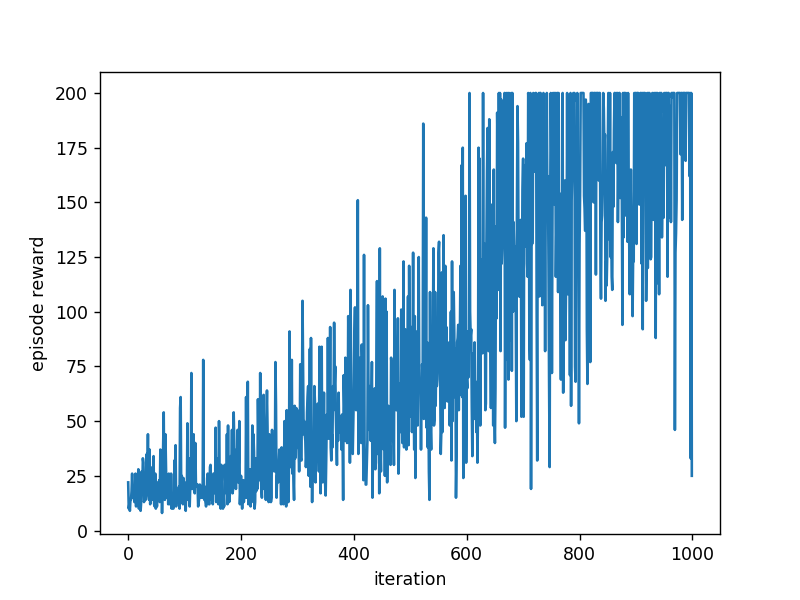

平均回合奖励 = 17975.0 / 100 = 179.75


In [15]:
policy_kwargs = {'hidden_sizes' : [], 'learning_rate' : 0.005}
agent = VPGAgent(env, policy_kwargs=policy_kwargs)

# 训练
episodes = 1000
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

episode_rewards = [play_montecarlo(env, agent, train=False)
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [20]:
play_montecarlo(env, agent, render = True)
env.close()

带基线：

In [ ]:
policy_kwargs = {'hidden_sizes' : [], 'learning_rate' : 0.005}
baseline_kwargs = {'hidden_sizes' : [], 'learning_rate' : 0.01}
agent = VPGAgent(env, policy_kwargs=policy_kwargs,
        baseline_kwargs=baseline_kwargs)

# 训练
episodes = 1000
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

# 测试
episode_rewards = [play_montecarlo(env, agent, train=False) \
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

## 异策回合更新策略梯度算法

引入重要性采样：
$$
\begin{aligned}
&\sum_a \pi(a|s;\theta)\gamma^tG_t\nabla\ln\pi(a|s;\theta) \\
&= \sum_ab(a|s)\frac{\pi(a|s;\theta)}{b(a|s)}\gamma^tG_t\nabla\ln\pi(a|s;\theta)\\
&=\sum_ab(a|s)\frac{1}{b(a|s)}\gamma^tG_t\nabla\pi(a|s;\theta)\\
\end{aligned}
$$
即
$$
E_{\pi(\theta)}[\gamma^tG_t\nabla\ln\pi(A_t|S_t;\theta)] = E_b\left[\frac{1}{b(A_t|S_t)}\gamma^tG_t\nabla\pi(A_t|S_t;\theta)\right]
$$
所以重要性采样的离线算法，只需要把用在在线策略采样得到的梯度方向$\gamma^tG_t\nabla\ln\pi(A_t|S_t;\theta)$改为用行为策略$b$采样得到的梯度方向$\frac{1}{b(A_t|S_t)}\gamma^tG_t\nabla\pi(A_t|S_t;\theta)$即可。这就意味着，在更新参数$\theta$时可以试图增大$\frac{1}{b(A_t|S_t)}\gamma^tG_t\pi(A_t|S_t;\theta)$

#### 算法实现

1. 初始化：$\theta \leftarrow any$
2. 回合更新：对每个回合执行以下操作：
   1. 行为策略：指定行为策略，使得$\pi(\theta) \ll b$
   2. 采样：用策略$b$生成轨迹$S_0,A_0,R_1,S_1,\dots,S_{T-1},A_{T-1},R_T,S_T$
   3. 初始化回报：$G \leftarrow 0$
   4. 对$t = T-1,T-2,\dots,0$执行以下操作：
      1. 更新回报：$G \leftarrow \gamma G + R_{t+1}$
      2. 更新策略：更新$\theta$以减小$-\frac{1}{b(A_t|S_t)}\gamma^tG_t\pi(A_t|S_t;\theta)$ （如$\theta_{t+1} \leftarrow \theta + \alpha \frac{1}{b(A_t|S_t)}\gamma^tG_t\nabla\pi(A_t|S_t;\theta)$）

重要性采样使得我们可以利用其他策略的样本来更新策略参数，但是可能会带来较大的偏差，算法稳定性比同策算法差。

In [ ]:
class RandomAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        
    def decide(self, observation):
        action = np.random.choice(self.action_n)
        behavior = 1. / self.action_n
        return action, behavior

In [ ]:
class OffPolicyVPGAgent(VPGAgent):
    def __init__(self, env, policy_kwargs, baseline_kwargs=None,
                gamma = 0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma

        self.trajectory = []

        def dot(y_true, y_pred):
            return -tf.reduce_sum(y_true * y_pred, axis=-1)
        
        self.policy_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax, loss=dot, **policy_kwargs)
        if baseline_kwargs:
            self.baseline_net = self.build_network(output_size=1,
                    **baseline_kwargs)
    def learn(self, observation, action, behavior, reward, done):
        self.trajectory.append((observation, action, behavior, reward))

        if done:
            df = pd.DataFrame(self.trajectory, columns=
                    ['observation', 'action', 'behavior', 'reward'])
            df['discount'] = self.gamma ** df.index.to_series()
            df['discounted_reward'] = df['discount'] * df['reward']
            df['discounted_return'] = \
                    df['discounted_reward'][::-1].cumsum()
            df['psi'] = df['discounted_return']
            
            x = np.stack(df['observation'])
            if hasattr(self, 'baseline_net'):
                df['baseline'] = self.baseline_net.predict(x)
                df['psi'] -= df['baseline'] * df['discount']
                df['return'] = df['discounted_return'] / df['discount']
                y = df['return'].values[:, np.newaxis]
                self.baseline_net.fit(x, y, verbose=0)
                
            sample_weight = (df['psi'] / df['behavior']).values[:, np.newaxis]
            y = np.eye(self.action_n)[df['action']]
            self.policy_net.fit(x, y, sample_weight=sample_weight, verbose=0)
            
            self.trajectory = [] # 为下一回合初始化经验列表

不带基线：

In [ ]:
policy_kwargs = {'hidden_sizes' : [], 'learning_rate' : 0.06}
agent = OffPolicyVPGAgent(env, policy_kwargs=policy_kwargs)
behavior_agent = RandomAgent(env)

# 训练
episodes = 1000
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    observation = env.reset()
    episode_reward = 0.
    while True:
        action, behavior = behavior_agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        agent.learn(observation, action, behavior, reward, done)
        if done:
            break
        observation = next_observation
    
    # 跟踪监控
    episode_reward = play_montecarlo(env, agent, train=False)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

# 测试
episode_rewards = [play_montecarlo(env, agent, train=False)
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

带基线的重要性采样策略梯度算法：

In [ ]:
policy_kwargs = {'hidden_sizes' : [], 'learning_rate' : 0.06}
baseline_kwargs = {'hidden_sizes' : [], 'learning_rate' : 0.1}
agent = OffPolicyVPGAgent(env, policy_kwargs=policy_kwargs,
        baseline_kwargs=baseline_kwargs)
behavior_agent = RandomAgent(env)

# 训练
episodes = 1000
episode_rewards = []
chart = Chart()
for episode in range(episodes):
    observation = env.reset()
    episode_reward = 0.
    while True:
        action, behavior = behavior_agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        agent.learn(observation, action, behavior, reward, done)
        if done:
            break
        observation = next_observation
    
    # 跟踪监控
    episode_reward = play_montecarlo(env, agent, train=False)
    episode_rewards.append(episode_reward)
    chart.plot(episode_rewards)

# 测试
episode_rewards = [play_montecarlo(env, agent, train=False)
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [17]:
env.close

<bound method Wrapper.close of <TimeLimit<CartPoleEnv<CartPole-v0>>>>